In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 1
!hostname
!pwd

v026.ib.bridges2.psc.edu
/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks


In [12]:
import sys, os
import numpy as np
import xarray as xr
import skimage
import torch
import matplotlib.pyplot as plt
nax = np.newaxis

os.environ['DDEBACKEND'] = 'pytorch'
import deepxde

sys.path.append('..')
%aimport mre_pinn

torch.cuda.is_available()

True

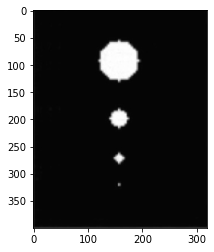

In [120]:
# read in the image file taken from the research article
im = skimage.io.imread('../data/BIOQIC/fem_box_ground_truth.png')
im = 1 - skimage.color.rgb2gray(im[...,:-1])[:,::-1].T
im = skimage.transform.resize(im, (4*100, 4*80), anti_aliasing=True)
im = (im - im.min()) / (im.max() - im.min()) # scale values to [0, 1]
plt.imshow(im, cmap='gray', vmin=0, vmax=1)

In [121]:
# get the grid coordinates of the image
x = mre_pinn.data.nd_coords_from_shape(im.shape, resolution=0.25)
y_true = im.reshape(-1)
x.shape, y_true.shape
x

array([[ 0.  ,  0.  ],
       [ 0.  ,  0.25],
       [ 0.  ,  0.5 ],
       ...,
       [99.75, 79.25],
       [99.75, 79.5 ],
       [99.75, 79.75]])

In [169]:
import torch

def disk(x, center, radius, power=2):
    dist = torch.norm(x - center, dim=1)
    return torch.exp(-(dist / radius)**(power * radius))

def forward(x, centers, radii=[10, 5, 2, 1], background=3, target=9):
    y_pred = 0
    for c, r in zip(centers, radii):
        y_pred += disk(x, center=c[nax,:], radius=r)
    return y_pred

centers = torch.tensor([
    [23.20, 39.35],
    [49.65, 39.40],
    [67.85, 39.45],
    [80.00, 39.25]
], device='cuda')
print(centers)

# fit the centers to the image
x = torch.tensor(x, device='cuda')
im_true = torch.tensor(im, device='cuda')
centers = torch.nn.Parameter(centers + torch.normal(0, 1e-2, (4, 2)))
optimizer = torch.optim.Adam([centers], lr=1e-1)

def closure():
    optimizer.zero_grad()
    y_pred = forward(x, centers)
    im_pred = y_pred.reshape(im_true.shape)
    loss = torch.mean(torch.abs(im_true - im_pred))
    loss.backward()
    return loss

for i in range(1000):
    loss = optimizer.step(closure)
    if (i+1)%100 == 0:
        print(f'{i+1} {loss:.4f}')
        
print(centers)

y_pred = forward(x, centers)
im_pred = y_pred.reshape(im.shape).detach().cpu().numpy()
im_pred.sum()

tensor([[23.2000, 39.3500],
        [49.6500, 39.4000],
        [67.8500, 39.4500],
        [80.0000, 39.2500]])
100 0.0296


/tmp/ipykernel_70875/2986786133.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, device='cuda')


200 0.0296
300 0.0296
400 0.0296
500 0.0296
600 0.0296
700 0.0296
800 0.0296
900 0.0296
1000 0.0296
Parameter containing:
tensor([[23.1085, 39.3959],
        [49.5517, 39.3321],
        [67.8425, 39.5267],
        [80.0962, 39.3469]], requires_grad=True)


6164.267392056716

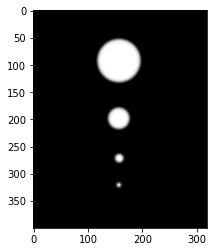

In [170]:
plt.imshow(im_pred, cmap='gray', vmin=0)

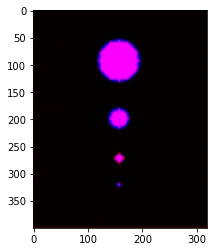

In [171]:
im_rgb = np.stack([im, np.zeros_like(im), im_pred], axis=-1)

plt.imshow(im_rgb, cmap='gray')

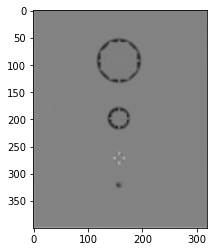

In [172]:
plt.imshow(im - im_pred, cmap='gray', vmin=-1, vmax=1)

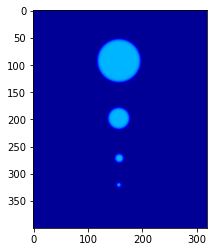

In [178]:
e_map = mre_pinn.visual.elast_color_map()
mu_bg = 3
mu_target = 9
mu = mu_bg + im_pred * (mu_target - mu_bg)
plt.imshow(mu, cmap=e_map, vmin=0, vmax=25)